# 颜色空间的转换-RGB和LUV

## LUV色彩空间

LUV色彩空间，也作CIELUV。是于1976年由国际照明委员会CIE 提出，由CIE XYZ空间经简单变换得到，具视觉统一性。

### 基本介绍

LUV色彩空间全称CIE 1976(L*,u*,v*) （也作CIELUV）色彩空间，L*表示物体亮度，u*和v*是色度。于1976年由国际照明委员会CIE 提出，由CIE XYZ空间经简单变换得到，具视觉统一性。类似的色彩空间有CIELAB。对于一般的图像，u*和v*的取值范围为-100到+100，亮度为0到100。
![](doc_imgs/43.jpg)

### 转换

UV色彩空间介绍及从RGB到LUV的转换

CIE 1931 XYZ 色彩空间（也叫做 CIE 1931 色彩空间）是其中一个最先采用数学方式来定义的色彩空间，它由国际照明委员会（CIE）于1931年创立。人类眼睛有对于短（S）、中（M）和长（L）波长光的感受器（叫做视锥细胞），所以原则上只要三个参数便能描述颜色感觉了。在三色加色法模型中，如果某一种颜色和另一种混合了不同份量的三种原色的颜色，均使人类看上去是相同的话，我们把这三种原色的份量称作该颜色的三色刺激值。 CIE 1931 色彩空间通常会给出颜色的三色刺激值，并以X、Y和Z来表示。

因为人类眼睛有响应不同波长范围的三种类型的颜色传感器，所有可视颜色的完整绘图是三维的。但是颜色的概念可以分为两部分：明度和色度。例如，白色是明亮的颜色，而灰色被认为是不太亮的白色。换句话说，白色和灰色的色度是一样的，而明度不同。

CIE xyY空间是由 XYZ值导出的空间， Y 是颜色的明度或亮度。x和y是CIE xy色度坐标，它们是所有三个三色刺激值 X、Y 和 Z 的函数所规范化的三个值中的两个：

![](doc_imgs/44.jpg)

1.RGB to CIE XYZ:

![](doc_imgs/45.png)

2.CIE XYZ to CIE LUV:

![](doc_imgs/46.png)
![](doc_imgs/47.png)

在这里u'和v'是色度坐标。CIE 1976色度图如下：

![](doc_imgs/48.png)

## 代码实现如下：

In [73]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from pyexcel_xls import get_data
import pandas as pd
from pandas import DataFrame
import math
import scipy
from scipy import linalg

In [74]:
src = cv2.cvtColor(cv2.imread('../datas/f2.jpg'),cv2.COLOR_BGR2RGB)

In [91]:
illuminants = \
    {"A": {'2': (1.098466069456375, 1, 0.3558228003436005),
           '10': (1.111420406956693, 1, 0.3519978321919493)},
     "D50": {'2': (0.9642119944211994, 1, 0.8251882845188288),
             '10': (0.9672062750333777, 1, 0.8142801513128616)},
     "D55": {'2': (0.956797052643698, 1, 0.9214805860173273),
             '10': (0.9579665682254781, 1, 0.9092525159847462)},
     "D65": {'2': (0.95047, 1., 1.08883),   # This was: `lab_ref_white`
             '10': (0.94809667673716, 1, 1.0730513595166162)},
     "D75": {'2': (0.9497220898840717, 1, 1.226393520724154),
             '10': (0.9441713925645873, 1, 1.2064272211720228)},
     "E": {'2': (1.0, 1.0, 1.0),
           '10': (1.0, 1.0, 1.0)}}

def get_xyz_coords(illuminant, observer):
    illuminant = illuminant.upper()
    try:
        return illuminants[illuminant][observer]
    except KeyError:
        raise ValueError("Unknown illuminant/observer combination\
        (\'{0}\', \'{1}\')".format(illuminant, observer))

def _prepare_colorarray(img):
    shape = img.shape
    return np.reshape(img,(shape[0] * shape[1],shape[2]))

def xyz2luv(xyz,illuminant="D65", observer="2"):
    arr = _prepare_colorarray(xyz)
    shape = xyz.shape
    # extract channels
    x, y, z = arr[..., 0], arr[..., 1], arr[..., 2]

    eps = np.finfo(np.float).eps

    # compute y_r and L
    xyz_ref_white = get_xyz_coords(illuminant, observer)
    L = y / xyz_ref_white[1]
    mask = L > 0.008856
    L[mask] = 116. * np.power(L[mask], 1. / 3.) - 16.
    L[~mask] = 903.3 * L[~mask]

    u0 = 4 * xyz_ref_white[0] / np.dot([1, 15, 3], xyz_ref_white)
    v0 = 9 * xyz_ref_white[1] / np.dot([1, 15, 3], xyz_ref_white)

    # u' and v' helper functions
    def fu(X, Y, Z):
        return (4. * X) / (X + 15. * Y + 3. * Z + eps)

    def fv(X, Y, Z):
        return (9. * Y) / (X + 15. * Y + 3. * Z + eps)

    # compute u and v using helper functions
    u = 13. * L * (fu(x, y, z) - u0)
    v = 13. * L * (fv(x, y, z) - v0)

    luv = np.concatenate([q[..., np.newaxis] for q in [L, u, v]], axis=-1)
    return np.reshape(luv,shape)

xyz_from_rgb = np.array([[0.412453, 0.357580, 0.180423],
                         [0.212671, 0.715160, 0.072169],
                         [0.019334, 0.119193, 0.950227]])

rgb_from_xyz = linalg.inv(xyz_from_rgb)

def rgb2xyz(img_rgb):
    shape = img_rgb.shape
    rgb = np.float64(img_rgb)
    arr = np.reshape(rgb,(shape[0] * shape[1],shape[2]))
    xyz = np.dot(arr,xyz_from_rgb.T.copy())
    xyz = np.reshape(xyz,shape)
    return xyz

def xyz2rgb(img_xyz):
    shape = img_xyz.shape
    xyz = np.float64(img_xyz)
    arr = np.reshape(xyz,(shape[0] * shape[1],shape[2]))
    rgb = np.dot(arr,rgb_from_xyz.T.copy())
    rgb = np.reshape(rgb,shape)
    return cv2.convertScaleAbs(rgb)

def luv2xyz(img_luv,illuminant="D65", observer="2"):
    shape = img_luv.shape
    arr = _prepare_colorarray(luv).copy()

    L, u, v = arr[..., 0], arr[..., 1], arr[..., 2]

    eps = np.finfo(np.float).eps

    # compute y
    y = L.copy()
    mask = y > 7.999625
    y[mask] = np.power((y[mask] + 16.) / 116., 3.)
    y[~mask] = y[~mask] / 903.3
    xyz_ref_white = get_xyz_coords(illuminant, observer)
    y *= xyz_ref_white[1]

    # reference white x,z
    uv_weights = [1, 15, 3]
    u0 = 4 * xyz_ref_white[0] / np.dot(uv_weights, xyz_ref_white)
    v0 = 9 * xyz_ref_white[1] / np.dot(uv_weights, xyz_ref_white)

    # compute intermediate values
    a = u0 + u / (13. * L + eps)
    b = v0 + v / (13. * L + eps)
    c = 3 * y * (5 * b - 3)

    # compute x and z
    z = ((a - 4) * c - 15 * a * b * y) / (12 * b)
    x = -(c / b + 3. * z)

    xyz = np.concatenate([q[..., np.newaxis] for q in [x, y, z]], axis=-1)
    return np.reshape(xyz,shape)

def rgb2luv(src):
    return xyz2luv(rgb2xyz(src))

def luv2rgb(src):
    return xyz2rgb(luv2xyz(src))

Text(0.5,1,'RGB->XYZ')

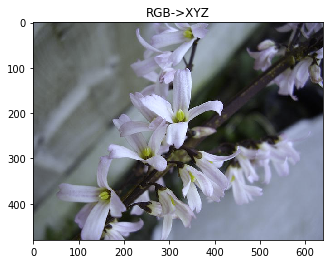

In [92]:
xyz = rgb2xyz(src)
plt.imshow(cv2.convertScaleAbs(xyz))
plt.title('RGB->XYZ')

Text(0.5,1,'XYZ->RGB')

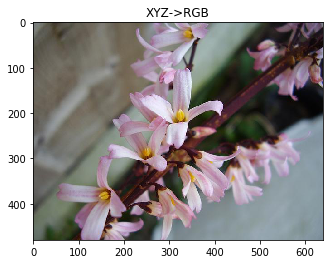

In [93]:
rgb = xyz2rgb(xyz)
plt.imshow(rgb)
plt.title('XYZ->RGB')

Text(0.5,1,'XYZ->LUV')

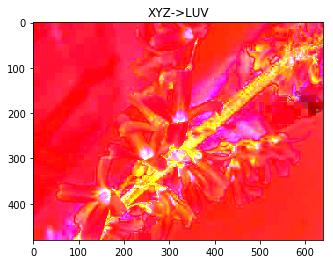

In [96]:
luv = xyz2luv(xyz)
plt.imshow(cv2.convertScaleAbs(luv))
plt.title('XYZ->LUV')

Text(0.5,1,'RGB->LUV')

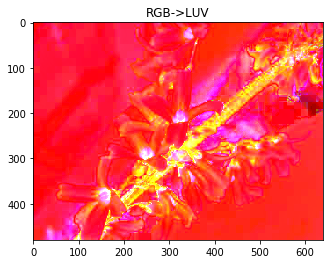

In [97]:
luv = rgb2luv(src)
plt.imshow(cv2.convertScaleAbs(luv))
plt.title('RGB->LUV')

Text(0.5,1,'LUV->RGB')

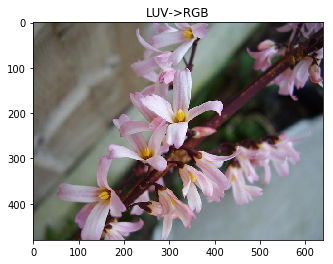

In [98]:
rgb = luv2rgb(luv)
plt.imshow(cv2.convertScaleAbs(rgb))
plt.title('LUV->RGB')

参考:

[1].https://baike.baidu.com/item/LUV%E8%89%B2%E5%BD%A9%E7%A9%BA%E9%97%B4/5893073?fr=aladdin

[2].https://blog.csdn.net/kit_147/article/details/5485470